Set the trigger to manual on the laser console.

In [36]:
import numpy as np
import pathlib
import pyvisa
import time
import matplotlib.pyplot as plt
import math
from datetime import datetime
TODAY_STR = datetime.now().strftime("%Y%m%d")
print(f"\x1b[1;3;4;96mDate of running the code:\x1b[0m \x1b[1;3;4;92m{TODAY_STR}\x1b[0m")
print(f"Time of running the code: {datetime.now().strftime("%H:%M:%S")}")

Date of running the code: 20241018
Time of running the code: 13:56:25


In [37]:
# Always run this: device communication
rm = pyvisa.ResourceManager()
rm.list_resources()

('TCPIP::169.254.112.67::INSTR',
 'TCPIP::169.254.112.67::INSTR',
 'TCPIP::169.254.112.67::INSTR',
 'TCPIP::169.254.112.67::INSTR')

In [39]:
# # oscilloscope connection
# Open the connection to the oscilloscope using its IP address
oscilloscope = rm.open_resource('TCPIP::169.254.112.67::INSTR', open_timeout=5000) # For the RIGOL DHO1204 in A*STAR

# Send a command to verify connection (e.g., identify the instrument)
# Sanity check for successful communication with oscilloscope
response = oscilloscope.query('*IDN?')
print(response)

RIGOL TECHNOLOGIES,DHO1204,HDO1B261900518,00.02.12



In [40]:
oscilloscope.write(':TIMebase:ROLL 0')
oscilloscope.write(':ACQuire:MDEPth 1M')    # Check again if this command is working! If not manually set MemDepth
oscilloscope.write(':TIMebase:MAIN:SCALe 2')
oscilloscope.write(':CHANnel1:SCALe 2')
oscilloscope.write(':CHANnel1:OFFSet 0')
oscilloscope.write(':TIMebase:MAIN:OFFSet 0')

25

In [7]:
# # Laser connection (laser is TSL)
# is_connect_success = False 
# while not is_connect_success:
#     try:
#         TSL = rm.open_resource("TCPIP::169.254.82.30::5000::SOCKET", read_termination="\r")
#         print(TSL.query("*IDN?"))
#         print("\x1b[0;92mTSL Connection established.\x1b[0m")
#         is_connect_success = True
#     except pyvisa.VisaIOError:
#         print("Retrying...")
#         time.sleep(0.5)

# if TSL.query(":POW:STAT?") == "+0":
#     TSL.write(":POW:STAT 1")
#     time.sleep(300)
#     print("Laser was off. Turning on laser.")

In [47]:
# Function to set up and enable triggering
def setup_trigger(trigger_level, trigger_source='CHAN1'):
    # Set the trigger source (e.g., Channel 1)
    oscilloscope.write(f':TRIGger:EDGE:SOURce {trigger_source}')
    
    # Set the trigger level (e.g., 0.5V)
    oscilloscope.write(f':TRIGger:EDGE:LEVel {trigger_level}')
    
    # Set the trigger type (e.g., edge trigger on a rising edge)
    oscilloscope.write(':TRIGger:EDGE:SLOPe POSitive')

    # Set the trigger sweep mode
    oscilloscope.write(':TRIGger:SWEep SINGle')
    
    print(f"Trigger set to {trigger_level}V on {trigger_source}.")


oscilloscope.write(':STOP') # Quickly "engineering reset" the oscilloscope

oscilloscope.write(':RUN') # Need oscilloscope to start running before it can capture anything
# The trigger will automatically start capturing once the trigger is detected

# Arm the trigger
setup_trigger(trigger_level=1)  # Unit of trigger_level is V
print("Trigger armed")

# Record the initial timestamp
last_print_time = time.time()

while 1:
    if oscilloscope.query(':TRIGger:STATus?').strip() == 'TD':
        print("Triggered! Starting capture; it will stop by itself.")
        break
    elif oscilloscope.query(':TRIGger:STATus?').strip() == 'WAIT':
        # Get the current time
        current_time = time.time()
        # Check if 5 seconds (or any interval you prefer) have passed since the last print
        if current_time - last_print_time >= 4:  # Adjust the interval as needed (e.g., 5 seconds)
            print("The oscilloscope is waiting. Trigger the laser manually again.")
            last_print_time = current_time  # Update the timestamp for the next interval

Trigger set to 1V on CHAN1.
Trigger armed
The oscilloscope is waiting. Trigger the laser manually again.
The oscilloscope is waiting. Trigger the laser manually again.
Triggered! Starting capture; it will stop by itself.


Querying waveform data for channel 1
Querying waveform data for channel 2


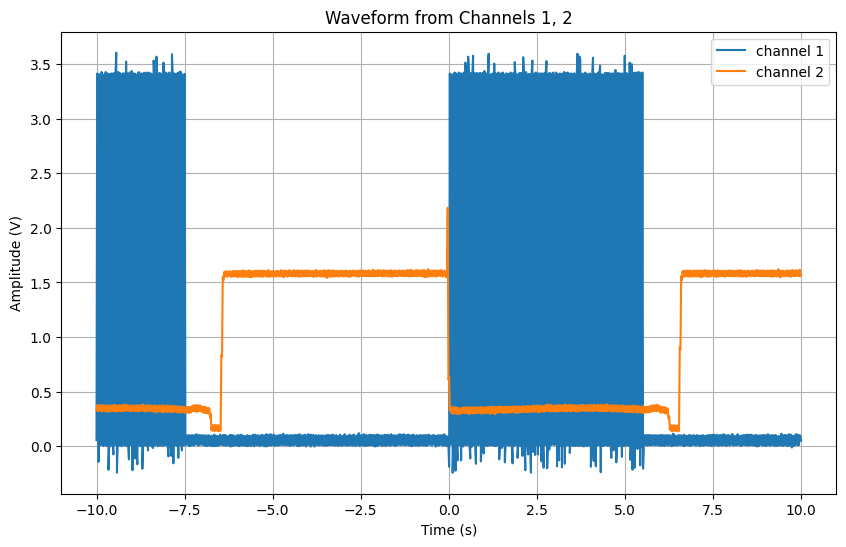

In [55]:
waveforms = {}

def plot_and_save_waveform(channels: list[int]):

    for ch in channels:
        # Select the channel
        oscilloscope.write(f':WAV:SOUR CHAN{ch}')

        # Set the waveform format to ASCII (can also use 'BYTE' or 'WORD' for binary)
        oscilloscope.write(':WAV:FORM ASCII')

        # Get the waveform data
        print(f"Querying waveform data for channel {ch}")
        data = oscilloscope.query(':WAV:DATA?')

        # Parse the data (it's returned as a comma-separated string in ASCII mode)
        waveform_data = np.array([float(i) for i in data.split(',')])
        waveforms[f"waveform_ch{ch}"] = waveform_data

        # Get the X-axis scale and position (Time per division, etc.)
        x_increment = float(oscilloscope.query(':WAV:XINC?'))
        x_origin = float(oscilloscope.query(':WAV:XOR?'))

        # Generate the time axis
        time_axis = np.linspace(x_origin, x_origin + x_increment * len(waveform_data), len(waveform_data))
        waveforms[f"time_axis_ch{ch}"] = time_axis

        # Generate a timestamp for the file name
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        csvfilename = f"C:/Users/groov/VSCode/CSV_Waveforms/waveform_{timestamp}_channel{ch}.csv"

        # Save the waveform data to a CSV file
        np.savetxt(csvfilename, np.column_stack((time_axis, waveform_data)), delimiter=",", header="Time, Amplitude")

    # Plot the waveform for visualization
    plt.figure(figsize=(10, 6))
    for ch in channels:
        plt.plot(waveforms[f"time_axis_ch{ch}"],  waveforms[f"waveform_ch{ch}"], label=f"channel {ch}")
    plt.title("Waveform from Channels " + ", ".join(str(ch) for ch in channels))
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (V)")
    plt.grid(True)
    plt.legend()
    # plt.savefig(f"waveform_channel_{channel}_{timestamp}.png")
    plt.show()
        

# Call the function
plot_and_save_waveform(channels=[1,2])

## This plots on the same plot for consistency. However, if we want to change the variables slightly, can do
